© 2022 Rachel Banks and Soichi Hirokawa. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT) 

This exercise was generated from a Jupyter notebook. You can download the notebook [here](mrna_counts_pboc22mars.ipynb).
___

# Stochastic simulations through mRNA counting with a constitutive promoter

## Objective

In this notebook, we will expand upon our discussion of constitutive promoters and begin to familiarize ourselves with stochastic simulations by examining the number of mRNA based on production and degradation rates. Stochastic simulations involve randomly drawing numbers, typically between 0 and 1, to determine whether an event has occurred or not and updating the state of the
system based on the rules of the outcome. We will use `numpy`'s pseudorandom 
number
generators to examine how the mRNA count changes first by production alone
and then by accounting for degradation.

To begin, suppose an event occurs with a rate $r$. If we look at a small time interval $\Delta t$ such that the probability $r \Delta t \ll 1$, then we can
take that small $\Delta t$ increment in time and ask if we saw an event occur.
Essentially, this is like flipping a biased coin where the chances of getting
heads is $r \Delta t$. In many cases, our answer might be "no." In this case,
we can take another time step and ask again if the event occurs. Eventuallly,
we will get an answer "yes" and we will update our system based on the rules
of the event. In the case of mRNA production with production rate $r_\text{prod}$,
we would add 1 mRNA if our answer comes back as "yes." Let's import some
packages and define the parameters of our simulation.

In [ ]:
# import relevant packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize 

%matplotlib inline

In [ ]:
# define parameters

# production rate of rna
r_prod = 1/10 # molecules / min

# time intervals
dt = 0.01 # min

# total time
time = 1000 # min

# time steps
n_steps = int(time / dt)


For our simulation, we will create an array that will contain our mRNA counts.
We will use `numpy`'s `random.rand()` function, which will generate a number
between 0 and 1. This is so that we can compare it against a probability. If it
were a fair coin, we would be asking if we flipped heads ($< 0.5$) or tails 
($\geq 0.5$). In our case, when we draw out a number $x$, we will be asking if 
the event occurs $\left( x < r_\text{prod} \Delta t \right)$ or if the event
does not occur $\left( x \geq r_\text{prod} \Delta t \right)$. In addition, we
will take note of the time step when we add a new mRNA.

In [ ]:
# array for mRNA counts
rna = np.zeros(n_steps)

# empty array for tracking time steps when production occurs
prod_times = []

# compute the probability of mRNA production
prob_event = r_prod * dt

for t in range(1, n_steps):
  # draw a random number for [0,1)
  rand_num = np.random.rand()

  # is the number drawn smaller than the probability of the event?
  if rand_num < prob_event:
    # if yes, add an mRNA
    rna[t] = rna[t-1] + 1

    # note this time step
    prod_times = np.append(prod_times, t)
  else:
    # if no, the mRNA is the same as the previous time step
    rna[t] = rna[t-1]

Let's see a plot of this.

Text(0, 0.5, 'number of rna')

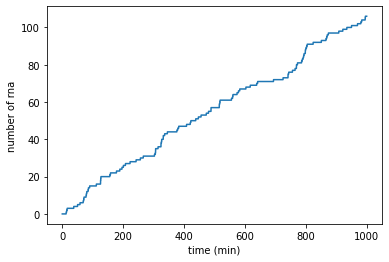

In [ ]:
# Create an array of times
times = np.arange(n_steps) * dt

# Plot the mRNA count in time
plt.plot(times, rna)
plt.xlabel('time (min)')
plt.ylabel('number of rna')

You will notice in the plot above that the production of mRNA is not a perfectly straight line. If you were to run this simulation with fewer time 
steps, you would see that the time between mRNA production is not constant.
This nonuniformity reveals the stochastic part. There may be some times where
I flip a coin 10 times and get heads all 10 times. Similarly, we might see an
event occur after fewer time steps than other times. Let's take the array that
contains the time steps when we added an mRNA and convert it to a time between
mRNA productions (which I will start to call the waiting time between events).
To do so, we will ues the function `np.diff`, which will take the difference in
consecutive values in the array of interest. We will then multiply by `dt` to
convert to time. We will then make a histogram to see how frequently we get
different waiting times.

Text(0, 0.5, 'count')

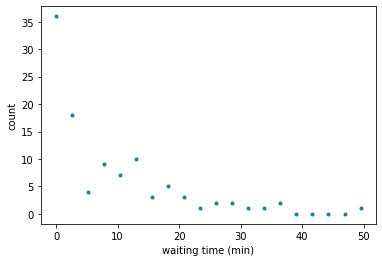

In [ ]:
# obtain waiting times
waiting_times = np.diff(prod_times) * dt

# bin waiting times into counts across 20 bins
counts, bins = np.histogram(waiting_times, bins=20)

# bins tells me my starting and ending values for each bin. Let's use the lower values for plots
plt.plot(bins[:-1], counts, '.')
plt.xlabel('waiting time (min)')
plt.ylabel('count')

Interesting. We can see that we get short waiting times (less than 3 minutes) 
more frequently than longer ones. You might remember that we saw that the
probability of an event occuring at a time $t$ is proportional to an exponent
\begin{equation}
  p \left( N \text{ waiting steps} \right) \propto \exp \left( - r t \right). \tag{1}
\end{equation}
In that case, we should be able to fit out data to an exponential of the form
$ a \exp \left( - b t \right)$ and recover our rate $r$. We will use `scipy.optimize` to do see this.

In [ ]:
# Create an exponential function
def exp_func(x, a, b):
  return a*np.exp(- b * x)

# params gives the best fit values for a and b. Ignore the second set of values returned with _
params, _ = scipy.optimize.curve_fit(exp_func, bins[0:-1], counts)
params

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


array([33.36482473,  0.19241472])

We can see that indeed, we recover a number fairly close to $r$. Let's overlay
the best with the binned observation counts.

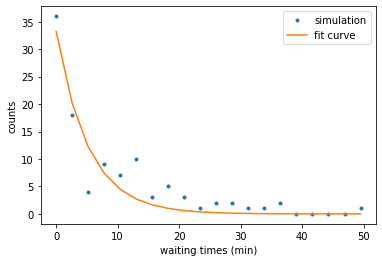

In [ ]:
plt.plot(bins[:-1], counts, '.', label='simulation')

ys = exp_func(bins[:-1], params[0], params[1])

plt.plot(bins[0:-1], ys, label='fit curve')
plt.xlabel('waiting times (min)')
plt.ylabel('counts')
plt.legend()

The agreement looks nice! This is a useful way of seeing that when I am
repeatedly asking after time $\Delta t$ whether an event occurred that the
number of consecutive times I don't see an event is exponentially distributed.

## Including degradation

Now that we have a better sense for how stochastic simulations work, we will
include degradation. Remember from our master equation that the mRNA counts
at the next time step $t + \Delta t$ is determined by
\begin{equation}
  m \left( t + \Delta t \right) = m \left( t \right) + r_\text{prod} \Delta t - \gamma \Delta t \, m \left( t \right), \tag{2}
\end{equation}
where $\gamma$ is the degradation rate. Notice then that while production does
not get any faster or slower with mRNA, the degradation term becomes more 
prominent when the mRNA counts increase. We then see that a degradation event
has an mRNA-dependent probability that I will need to factor in. This means
I have two probabilities I need to consider:
\begin{align}
  p_\text{prod} &= r_\text{prod} \Delta t, \tag{3} \\
  p_\text{deg} &= \gamma \Delta t \, m \left( t \right). \tag{4}
\end{align}

How do we factor in that we have two probabilities? There are a couple of ways
to go about this. The first option is to ask whether either of those two events
occurred and comparing our randomly drawn number to the sum of the probabilities. If the answer is "yes" we would need to flip another coin to 
determine which of the two outcomes occurred. This would require **nesting** an
`if` statement into another `if` statement, which will be useful for us in a
later notebook, particularly when we have more than 2 outcomes and a rare decision that we will need to make.

An alternative way is to break up
a number line that goes from 0 to 1 into three parts. We can say that if the
randomly drawn number falls between 0 and $p_\text{prod}$, then we will have a
production of mRNA. If the number falls between $p_\text{prod}$ and $p_\text{prod} + p_\text{deg}$, then an mRNA is degraded. And if the number falls between
$p_\text{prod} + p_\text{deg}$ and 1, then nothing happens and we keep the same
number of mRNA. We will use the latter example to learn about what happens when
we don't satisfy our `if` statement but have an alternative option we want to
consider before we resort to using `else`.

In [ ]:
# define degradation rate and production rate
gamma = 1 / 30 # min^-1
r_prod = 1 / 3 # mRNA / min

# total time
time = 200 # min

# time interval
dt = 0.01

# time steps
n_steps = int(time / dt)

# create an array for mRNA counts
rna = np.zeros(n_steps)

# compute the probability of production; this is fixed
prob_prod = r_prod * dt

for t in range(1, n_steps):
  # note the degradation probability based on the previous mRNA count
  prob_deg = gamma * dt * rna[t-1]

  # determine if an event has happened
  rand_num = np.random.rand()

  # if it falls in the production bin, add 1 mRNA
  if rand_num < prob_prod:
    rna[t] = rna[t-1] + 1

  # if it falls in the degradation bin, subtract 1 mRNA; parentheses help us organize our conditions
  elif (rand_num >= prob_prod) and (rand_num < prob_prod + prob_deg):
    rna[t] = rna[t-1] - 1

  # otherwise, the mRNA count is the same
  else:
    rna[t] = rna[t-1]

Text(0, 0.5, 'number of RNA')

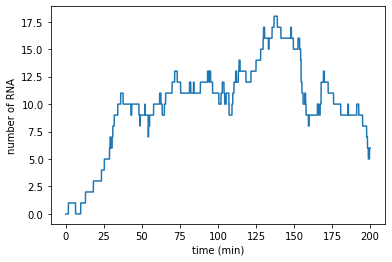

In [ ]:
# plot the mRNA counts in real time
times = np.arange(n_steps) * dt

plt.plot(times, rna)
plt.xlabel('time (min)')
plt.ylabel('number of RNA')

We can see the mRNA count increasing at first then start to fluctuate. However,
one of the powers of using stochastic simulations is to run the simulation
repeatedly and looking at the statistics, such as the average mRNAa counts in
time. To do so, we will alter `rna` to store the mRNA counts at each time step 
for each run. 

In [ ]:
# define degradation rate and production rate
gamma = 1 / 30 # min^-1
r_prod = 1 / 3 # mRNA / min

# total time
time = 200 # min

# time interval
dt = 0.01

# time steps
n_steps = int(time / dt)

# Include run steps
n_runs = 100

# Redefine array to include mRNA counts for each run
rna = np.zeros((n_runs, n_steps))

# compute the probability of production
prob_prod = r_prod * dt

for j in range(n_runs):
  for t in range(1, n_steps):
    # note the degradation probability based on the previous mRNA count
    prob_deg = gamma * dt * rna[j, t-1]

    # determine if an event has happened
    rand_num = np.random.rand()

    # if it falls in the production bin, add 1 mRNA
    if rand_num < prob_prod:
      rna[j, t] = rna[j, t-1] + 1

    # if it falls in the degradation bin, subtract 1 mRNA; parentheses help us organize our conditions
    elif (rand_num >= prob_prod) and (rand_num < prob_prod + prob_deg):
      rna[j, t] = rna[j, t-1] - 1

    # otherwise, the mRNA count is the same
    else:
      rna[j, t] = rna[j, t-1]

Let's plot the data with some transparency and compare to the average.

Text(0, 0.5, 'number of mRNA')

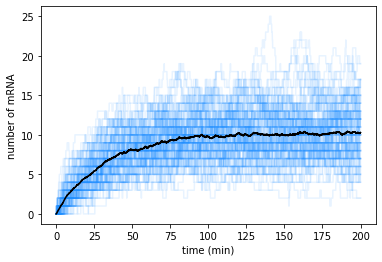

In [ ]:
# produce absolute times
times = np.arange(n_steps) * dt

# take the average mRNA count in time.
average = np.mean(rna, axis=0)

for t in range(n_runs):
  plt.plot(times, rna[t,:], alpha=0.1, color='dodgerblue')
# plot the average
plt.plot(times, average, color='k')
plt.xlabel('time (min)')
plt.ylabel('number of mRNA')

Though still exhibiting some fluctuations, we can see now that the average 
smoothly increases before plateauing around a fixed value. Fortunately, this is 
another case where we know the analytical solution. Recall that the ordinary differential equation for this problem is of the form
\begin{equation}
  \frac{\text{d} m}{\text{d} t} = r - \gamma \, m. \tag{5}
\end{equation}
We then made a slight modification by dividing both sides by $\gamma$ and
redefining our unit of time to a dimensionless time $t^* \equiv \gamma t$. We
further defined $m^* \equiv \frac{r}{\gamma}$ so that our equation looks
like
\begin{equation}
  \frac{\text{d} m}{\text{d} t^*} = m^* - m. \tag{6}
\end{equation}
Finally, we redefined our variable $\bar{m} = m^* - m$ and note that when
we take the derivative, we are left with
\begin{equation}
  \frac{\text{d} \bar{m}}{\text{d} t^*} = \frac{\text{d} m}{\text{d} t^*}, \tag{7}
\end{equation}
so that when we put everything into Eq. 6, we get
\begin{equation}
  \frac{\text{d} \bar{m}}{\text{d} t^*} = - \bar{m}. \tag{8}
\end{equation}
Eq. 8 looks very similar to the exponential growth, only now there is a minus
sign. We can think of it like having $k=-1$ for the exponential growth
case, so we have
\begin{equation}
  \bar{m} \left( t^* \right) = \bar{m}_0 e^{- t^*}. \tag{9}
\end{equation}
We can now return to our original variables $t$ and $m$ and if we take the 
initial condition that $m \left( 0 \right) = 0$, we get
\begin{equation}
  m(t) = \frac{r}{\gamma} \left( 1 - e^{- \gamma t} \right). \tag{10}
\end{equation}
Let's plot the average and the known values.

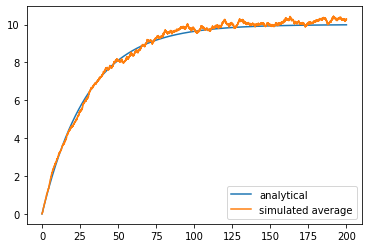

In [ ]:
time_soln = np.linspace(0, times.max(), 1000)
m_star = r_prod / gamma
analytical_soln = m_star - m_star * np.exp(- gamma * time_soln)

plt.plot(time_soln, analytical_soln, label='analytical')
plt.plot(times, average, label='simulated average')
plt.legend(loc=4)

Thus we can see that other than the small fluctuations, the average of the
different simulation runs falls along the expected 
steady-state mRNA count.